# Final Project

Our idea is find out what the Public opinion is on Twitter on the overturning of Roe v. Wade in large city’s in the US  and to investigate whether it corresponds with the laws in that state.

This notebook consists of different steps we performed to get to our goal:
1. Data Crawling
2. Data pre-processing
    - cleaning location
    - cleaning tweets
3. Data exploration
    - measure spread of tweets
    - wordclouds
4. Sentiment analysis
5. Modelling

# 1. Data crawling (retrieving and storing Twitter data)

First, we will import the Tweepy API, which we can use to retrieve tweets. We applied for Academic Research access, so we could retrieve tweets from a different period than only the tweets from the last seven days. We searched for tweets aroudn the time Roe V Wade overturned.

In [3]:
import tweepy

CONSUMER_KEY = 'pttmAvuj8z26khmI29Iy6Yvkt'
CONSUMER_SECRET = 'AxWg9dcVVFX1K9TrLUiecXBqpSZn4lu1qEJvIlAoWRRUDd9F9x'
OAUTH_TOKEN = '1364492577957965825-3Curg3S5QShUpIa3YcF7VpHJTGzSkT'
OAUTH_TOKEN_SECRET = 'md1dtliBClGRem1MDUpLMoCm4GtKXbkMsx54sZAeDpRNU'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAN29jwEAAAAA83MuicQ7VEXm9VY%2F68ZZ%2BGVht9I%3DAkULEZI8WPV44znUF6pVf0D8MHazsz2xh8jsq2I5UH9PCPxds7'

client = tweepy.Client(bearer_token)

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True)

We created a function to add new lines to files. We will create two files, one containing the tweets and the second containing the location.

In [4]:
def append_new_line(file_name, text_to_append):
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)

Here we specify the query, we want to find tweets containing the hashtag #RoeVwade. Furthermore we specify that the tweet is not a retweet and the country where the tweet has been posted is in the US. The timeframe we collect tweets is 5 days before Roe V. Wade overturned and five days after. Since there is a limit of tweets you can collect, we store the tweets and locations immeditately in a file. We included a sleep time to make sure we would not receive a too many request error. 

We can skip this code if we collected all tweets and locations in the files

In [5]:
#import time
#query = '#RoeVWade -is:retweet place_country:US'

#start_time = '2022-06-19T00:00:00Z'
#end_time = '2022-06-29T00:00:00Z'

#limit is 100
#for i in range(1500):
    #max_result=100

    #tweets = client.search_all_tweets(query=query, tweet_fields=['context_annotations', 'created_at', 'geo'],
    #                                  place_fields=['place_type', 'geo'], expansions='geo.place_id', 
    #                                  start_time=start_time, end_time=end_time, max_results=max_result)

    # Get list of places from includes object
    #places = {p["id"]: p for p in tweets.includes['places']}

    #for tweet in tweets.data:
        #text = tweet.text
        #if places[tweet.geo['place_id']]:
            #place = places[tweet.geo['place_id']]
            #place = place.full_name
        #text_to_append = (text + ': ' + place)
        #append_new_line('tweets.txt', text)
        #append_new_line('locations.txt', place)
    #time.sleep(2)

We collected 150000 tweets containing the hashtag #RoeVWade

Here we merge the two files into one dataframe consisting of a column of tweets and a column with locations.

In [6]:
import pandas as pd

df1 = pd.read_csv('tweets.txt', sep='\t', header=None, names=['Tweet'])
df2 = pd.read_csv('locations.txt', sep='\t', header=None, names=['Location'])


df = pd.concat([df1, df2], axis=1, join='inner')
print(len(df))
display(df.head(5))


150000


Tweet        Location
0  Democratic senators need to shut up and come u...  Wisconsin, USA
1  Overturning #RoeVWade is a public health crisi...   Cleveland, OH
2  SIGN NOW -&gt; Demand Congress stand up immedi...   Delaware, USA
3                  #RoeVWade https://t.co/VYMtMZVuHH    Evendale, OH
4  This days it all. #RoeVWade https://t.co/JvMFK...    Lea Hill, WA

# 2. Date Preprocessing


We performed multiple cleaning operations. First we clean the location and create one column containing the state abbreviation. Then we clean the tweet data.

### Clean Location

We retrieve the location from the tweets metadata, however, it is not always in the form we want. Overall the form is 'city', 'state abbreviation'. Lets start with splitting the location values into two columns. 

We focus on the second column, containing the state abbreviation. When looking at the unique values from that column below, we see that some values do not have the state abbreviation, but instead USA or None. Before continuing with our project we would like to clean this. In the end we want one column with only the state abbrevation.

In [7]:
df[['First','Last']] = df.Location.str.split(",",expand=True,)
df['Last'] = df['Last'].str.strip()

In [8]:
print(df.Last.unique())

['USA' 'OH' 'WA' 'MO' 'MN' 'GA' 'NY' 'CO' 'NV' 'MS' 'MI' None 'IN' 'LA'
 'TX' 'OR' 'DC' 'CA' 'NE' 'IA' 'SC' 'PA' 'MA' 'Philadelphia' 'NC' 'TN'
 'FL' 'Puerto Rico' 'HI' 'OK' 'AL' 'NJ']


We replace Philadelphia with the state it belongs to and we remove Puerto Rico.

In [9]:
import numpy as np

#Puerto Rico is part of the USA, but for simplicity we only use the states. 
df.drop(df.loc[df['Last']=='Puerto Rico'].index, inplace=True)

#We change philadelphia into the state it belongs to
df.loc[df["Last"] == 'Philadelphia', "Last"] = 'PA'

Some rows contain the value USA instead of the state abbreviation. Lets see what is in the first column when this happens. Below we see it happens for wisconsin, delaware, new york, colorado, kansas, florida, indiana and maine. These are all states, so we will loop through the rows and replace USA with the correct state abbreviation.

In [10]:
df2=df.loc[df['Last'] == 'USA', 'First']
df2.unique()

array(['Wisconsin', 'Delaware', 'New York', 'Colorado', 'Kansas',
       'Florida', 'Indiana', 'Maine'], dtype=object)

In [11]:
state_to_abbrev = {
    "Wisconsin": "WI",
    "Delaware": "DE",
    "New York": "NY",
    "Colorado": "CO",
    "Kansas": "KS",
    "Florida": "FL",
    "Indiana": "IN",
    "Maine": "ME"}


for i, row in df.iterrows():
    if row.Last == 'USA':
        df.at[i, 'Last'] = state_to_abbrev[row.First]

df.head(5)

Tweet        Location  \
0  Democratic senators need to shut up and come u...  Wisconsin, USA   
1  Overturning #RoeVWade is a public health crisi...   Cleveland, OH   
2  SIGN NOW -&gt; Demand Congress stand up immedi...   Delaware, USA   
3                  #RoeVWade https://t.co/VYMtMZVuHH    Evendale, OH   
4  This days it all. #RoeVWade https://t.co/JvMFK...    Lea Hill, WA   

       First Last  
0  Wisconsin   WI  
1  Cleveland   OH  
2   Delaware   DE  
3   Evendale   OH  
4   Lea Hill   WA

Now we focus on the None column, lets check what is in the first column when this happens. Below we see it happens for specific places, and the fast food place McDonald's. We remove the tweets located in McDonald's and we searched for the correct state of the other locations. 

In [12]:
df2=df.loc[df['Last'].isna(), 'First']
df2.unique()

array(['Downtown Springfield', 'Washington Square Park',
       'Fountains of Bellagio', "McDonald's"], dtype=object)

In [13]:
clean_dict = {
    "Downtown Springfield": "MO",
    "Washington Square Park": "NY",
    "Fountains of Bellagio": "NV"}

for i, row in df.iterrows():
    value = row['Last']
    if pd.isnull(value) and row.First != "McDonald's":
        df.at[i, 'Last'] = clean_dict[row.First]
    if pd.isnull(value) and row.First == "McDonald's":
        df.drop(i, inplace=True)


Lets see how many rows we have left. Wow a lot of the tweets were located in Mcdonalds. I wonder why the Mcdonalds is stored in the metadata instead of the actual location.

In [14]:
print(len(df))

146940


Below you can see the final dataframe

In [15]:
final_df = df[['Tweet', 'Last']].copy()
final_df.rename(columns={'Last':'Location'}, inplace=True)

final_df.head(5)

Tweet Location
0  Democratic senators need to shut up and come u...       WI
1  Overturning #RoeVWade is a public health crisi...       OH
2  SIGN NOW -&gt; Demand Congress stand up immedi...       DE
3                  #RoeVWade https://t.co/VYMtMZVuHH       OH
4  This days it all. #RoeVWade https://t.co/JvMFK...       WA

### Cleaning Twitter data

To clean the twitter data we perform multiple steps. We remove links from the tweets, we remove symbols,  we remove punctuation, tokenize the tweet and remove stopwords.

In [16]:
import string
import nltk
import re
stopword = nltk.corpus.stopwords.words('english')

def remove_link(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_punct(tweet):
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet

def tokenization(tweet):
    tweet = re.split('\W+', tweet)
    return tweet

def remove_stopwords(tweet):
    tweet = [word for word in tweet if word not in stopword]
    return tweet

We add a new column clean_tweet, where we performed the cleaning tasks

In [17]:
# It is a bit unclear if its better to keep the whole sentence or apply tokenization etc. for sentiment analysis. 
cleaned_df = final_df
cleaned_df['Clean_Tweet'] = cleaned_df['Tweet'].apply(lambda x: remove_stopwords(tokenization(remove_punct(remove_link(x.lower())))))
cleaned_df['Clean_Tweet'] = cleaned_df['Clean_Tweet'].apply(lambda x: ' '.join(x))
display(cleaned_df.head(10))

Tweet Location  \
0  Democratic senators need to shut up and come u...       WI   
1  Overturning #RoeVWade is a public health crisi...       OH   
2  SIGN NOW -&gt; Demand Congress stand up immedi...       DE   
3                  #RoeVWade https://t.co/VYMtMZVuHH       OH   
4  This days it all. #RoeVWade https://t.co/JvMFK...       WA   
5  A brilliant composer AND strategic thinker. @H...       NY   
6  #RoeVsWade #RoeVWade #TrumpCoupAttempt #TrumpI...       MO   
7  The AG continues to allow protesters to threat...       MN   
8  Mischa's Letting The Girls Loose @NYCPride ❤️🧡...       GA   
9  #freethenipples #Pride2022 #PrideMonth #NYCPri...       NY   

                                         Clean_Tweet  
0  democratic senators need shut come realistic s...  
1  overturning roevwade public health crisis clev...  
2  sign gt demand congress stand immediately prot...  
3                                          roevwade   
4                                     days roevwade   
5  brilliant composer strategic thinker hanszimme...  
6  roevswade roevwade trumpcoupattempt trumpisgui...  
7  ag continues allow protesters threaten justice...  
8              mischas letting girls loose nycpride   
9  freethenipples pride pridemonth nycpride stone...

# 3. Data exploration

### Investigate spread of the tweets

We collected 150000 tweets from different states. Below we visualized the count of the tweets per state.

In [18]:
tweets_per_state = pd.DataFrame(cleaned_df.Location.value_counts())
states = tweets_per_state.index.to_list() 
number_of_tweets = tweets_per_state.Location.to_list()
print(states, number_of_tweets)

['CA', 'FL', 'NY', 'MO', 'CO', 'OH', 'GA', 'DC', 'TX', 'MN', 'NV', 'IN', 'LA', 'MI', 'MS', 'PA', 'WA', 'MA', 'TN', 'WI', 'DE', 'SC', 'IA', 'NE', 'KS', 'OR', 'NC', 'HI', 'OK', 'AL', 'ME', 'NJ'] [16834, 16830, 13775, 9188, 9185, 6124, 6123, 6121, 6121, 4596, 4593, 4591, 4591, 3062, 3062, 3062, 3062, 3061, 3060, 1532, 1532, 1531, 1531, 1531, 1531, 1531, 1530, 1530, 1530, 1530, 1530, 1530]


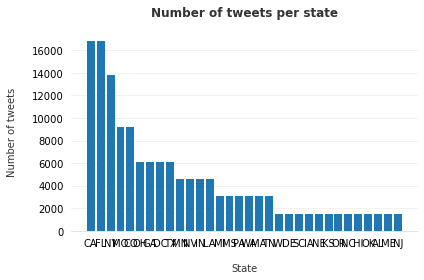

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=states,
    height=number_of_tweets,
    tick_label=states
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('State', labelpad=15, color='#333333')
ax.set_ylabel('Number of tweets', labelpad=15, color='#333333')
ax.set_title('Number of tweets per state', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()

We think we can create a better overview of the number of tweets per state. we will be using the plotly library to create a choropleth map from the states. 

In [20]:
tweet_count = final_df.groupby(['Location'])['Location'].count().reset_index(
    name='Count').sort_values(['Count'], ascending=False)

tweet_count.head(5)

Location  Count
1        CA  16834
5        FL  16830
22       NY  13775
16       MO   9188
2        CO   9185

In [21]:
#pip install plotly-express

import plotly
import plotly.express as px

location_list = tweet_count["Location"].to_numpy()
count_list = tweet_count["Count"].to_numpy()

fig = px.choropleth(locations=location_list, locationmode="USA-states", color=count_list, scope="usa",
                   labels={'color':'Tweet count'})
 
fig.show()

### Wordclouds

For the 5 locations with the highest count of tweets we created a worldcloud, to see what topics are mostly talked about. When comparing the wordclouds it can be seen that the topics talked about in the 5 states are very similar. There are a lot of tweets on topic like prochoice, rights, mybodymychoice. 

CA



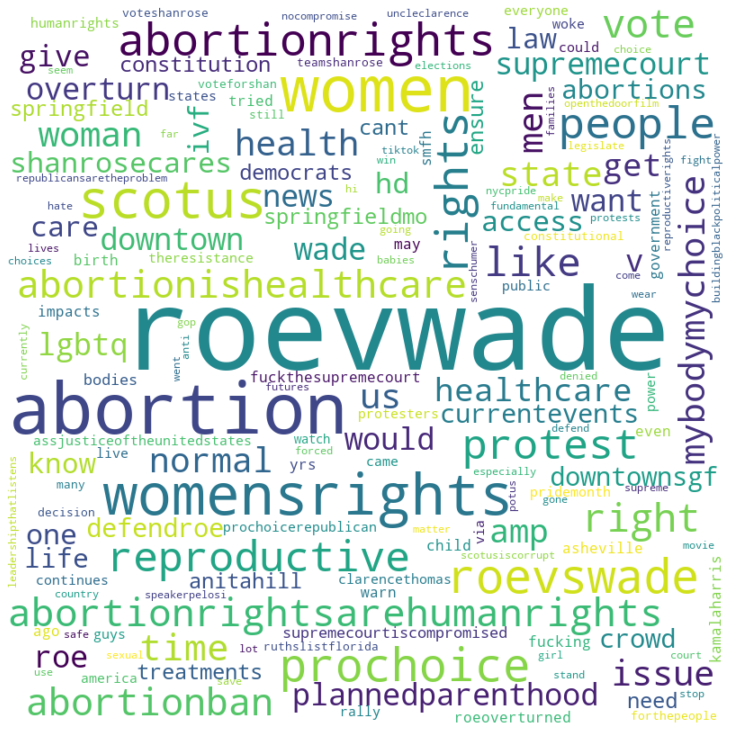

FL



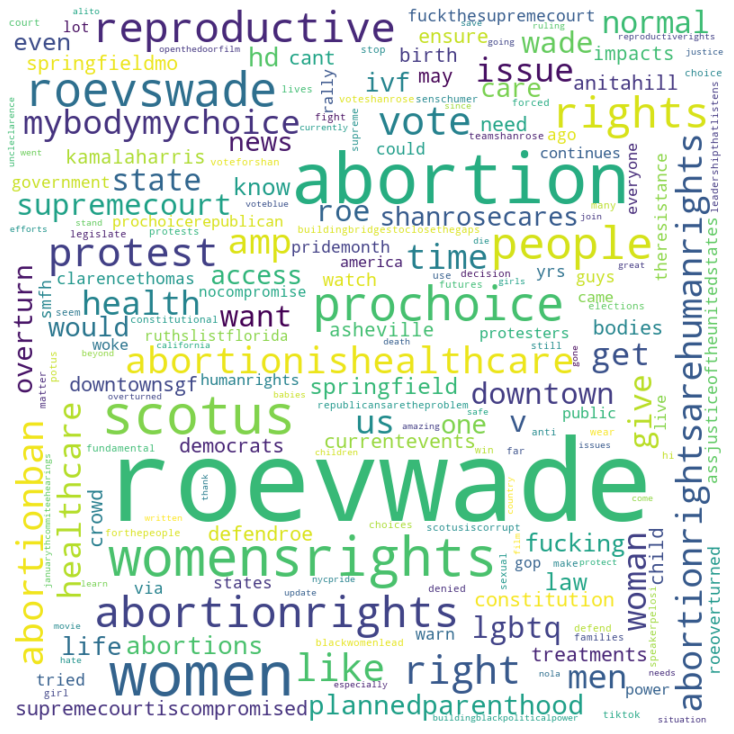

NY



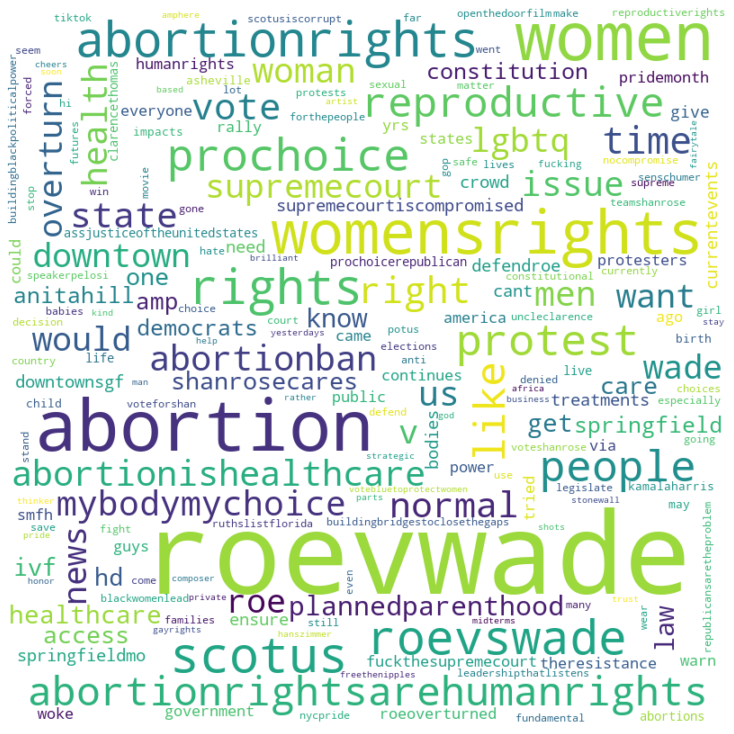

MO



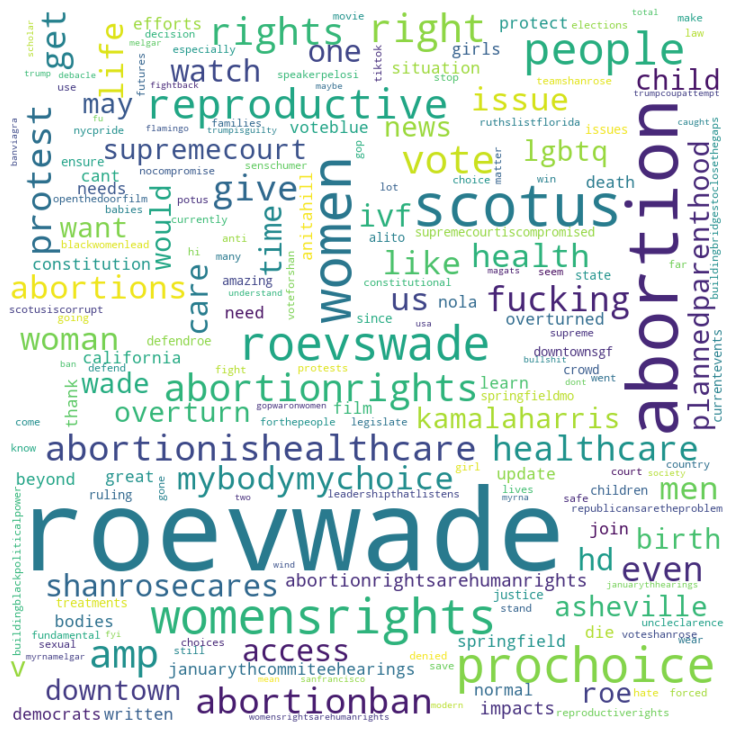

CO



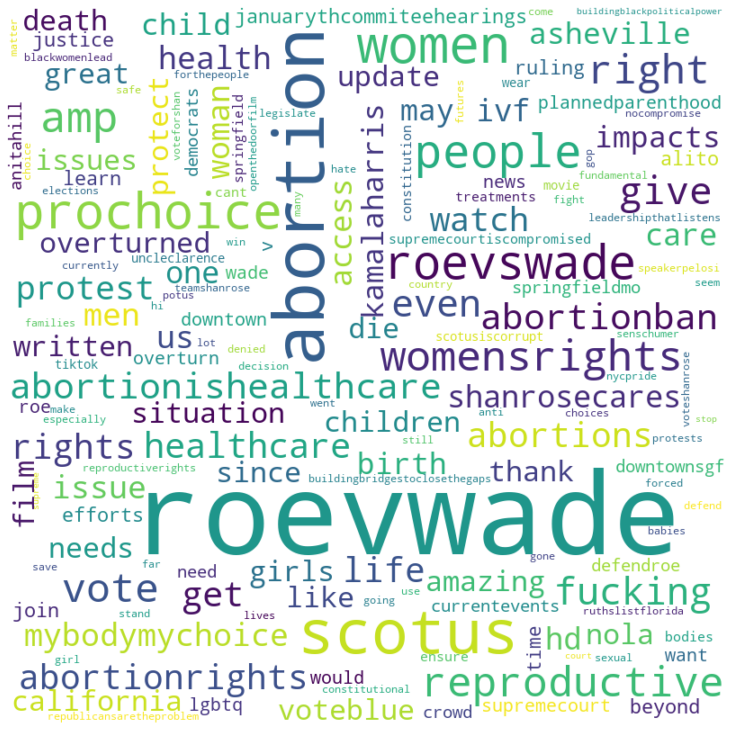

In [22]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

c = ['CA','FL','NY','MO','CO']

for l in c:
    
    print('\033[1m'+l+'\033[0m')
    print()

    cleaned_tweets = []
    for tweet in final_df['Tweet'][final_df['Location'] == l]:
        tweet = remove_stopwords(tokenization(remove_punct(remove_link(tweet.lower()))))
        tweet = list(filter(None, tweet))
        cleaned_tweets.append(tweet)

    total = Counter()
    for i in cleaned_tweets[0:]:
            total.update(i)


    dict(total)

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate_from_frequencies(total)

    # plot the WordCloud image
    plt.figure(figsize = (15, 10), facecolor = None) 
    plt.imshow(wordcloud,interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

# 4. Sentiment analysis

We import the sentiment analyzer from nltk to measure the sentiment per tweet. To see if the tweet is more negative, neutral or positive

In [23]:
import nltk 
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
cleaned_df['Sentiment'] = cleaned_df['Clean_Tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

display(cleaned_df.head(10))

Tweet Location  \
0  Democratic senators need to shut up and come u...       WI   
1  Overturning #RoeVWade is a public health crisi...       OH   
2  SIGN NOW -&gt; Demand Congress stand up immedi...       DE   
3                  #RoeVWade https://t.co/VYMtMZVuHH       OH   
4  This days it all. #RoeVWade https://t.co/JvMFK...       WA   
5  A brilliant composer AND strategic thinker. @H...       NY   
6  #RoeVsWade #RoeVWade #TrumpCoupAttempt #TrumpI...       MO   
7  The AG continues to allow protesters to threat...       MN   
8  Mischa's Letting The Girls Loose @NYCPride ❤️🧡...       GA   
9  #freethenipples #Pride2022 #PrideMonth #NYCPri...       NY   

                                         Clean_Tweet  Sentiment  
0  democratic senators need shut come realistic s...    -0.5975  
1  overturning roevwade public health crisis clev...    -0.2732  
2  sign gt demand congress stand immediately prot...     0.7506  
3                                          roevwade      0.0000  
4                                     days roevwade      0.0000  
5  brilliant composer strategic thinker hanszimme...     0.8020  
6  roevswade roevwade trumpcoupattempt trumpisgui...     0.0000  
7  ag continues allow protesters threaten justice...    -0.7096  
8              mischas letting girls loose nycpride     -0.3182  
9  freethenipples pride pridemonth nycpride stone...     0.3400

### Average sentiment per state 

For all states in our data we compute the mean sentiment of all the tweets posted in that state. For the average sentiment per state we exclude the tweets with a sentiment score of 0.0. They are completely neutral and can influence the average while they do not say a lot about the opinion on Roe V wade. See the dataframe above and the first tweet with a sentiment score of 0.0 After cleaning the tweet only contains the hashtag, thus there is not much to say about the opinion on Roe V Wade. 


In [24]:
#version with neutral tweets
df2 = cleaned_df.copy()
sentiment_per_state = df2.groupby(['Location'])['Sentiment'].mean().reset_index(name='Sentiment')

display(sentiment_per_state.head(5))

Location  Sentiment
0       AL   0.040287
1       CA   0.000659
2       CO   0.029931
3       DC   0.009140
4       DE   0.041024

In [25]:
#version without neutral tweets
no_neutral = cleaned_df.copy()
no_neutral = no_neutral[no_neutral.Sentiment != 0]

sentiment_state = no_neutral.groupby(['Location'])['Sentiment'].mean().reset_index(name='Sentiment')
sentiment_state.head(5)

Location  Sentiment
0       AL   0.117409
1       CA   0.001761
2       CO   0.085218
3       DC   0.024864
4       DE   0.119258

In [26]:
location_list = sentiment_state["Location"].to_numpy()
sentiment_list = sentiment_state["Sentiment"].to_numpy()

fig = px.choropleth(locations=location_list, locationmode="USA-states", color=sentiment_list, scope="usa",
                   labels={'color':'Mean Sentiment'})
 
fig.show()

### Number of pos, neg and neutral per state

In [34]:
count_df = sentiment_state.filter(['Location'], axis=1)
count_df['negative'] = 0
count_df['positive'] = 0
count_df['neutral'] = 0

display(count_df.head(5))

Location  negative  positive  neutral
0       AL         0         0        0
1       CA         0         0        0
2       CO         0         0        0
3       DC         0         0        0
4       DE         0         0        0

In [35]:
for i, row in cleaned_df.iterrows():
    sent_value = row['Sentiment']
    location = row['Location']
    if sent_value < 0:
        row_n = count_df[count_df['Location'] == location].index[0]
        value = (count_df.loc[row_n, 'negative'] + 1)
        count_df.at[row_n, 'negative'] = value
    elif sent_value > 0:
        row_n = count_df[count_df['Location'] == location].index[0]
        value = (count_df.loc[row_n, 'positive'] + 1)
        count_df.at[row_n, 'positive'] = value
    else:
        row_n = count_df[count_df['Location'] == location].index[0]
        value = (count_df.loc[row_n, 'neutral'] + 1)
        count_df.at[row_n, 'neutral'] = value
        
count_df.head(5)

Location  negative  positive  neutral
0       AL       240       285     1005
1       CA      3587      2716    10531
2       CO      1575      1651     5959
3       DC      1230      1020     3871
4       DE       240       287     1005

Below the percentages of negative/positive/neutral tweets can be seen for each state

In [36]:
#TODOO
#PERCENTAGES
perc_df = count_df.copy()
for i, row in perc_df.iterrows():
    total = row['negative'] + row['positive'] + row['neutral']
    perc_df.loc[i, "negative"] = round(row['negative'] / total * 100, 1)
    perc_df.loc[i, "positive"] = round(row['positive'] / total * 100, 1)
    perc_df.loc[i, "neutral"] = round(row['neutral'] / total * 100, 1)

perc_df.head(5)

Location  negative  positive  neutral
0       AL      15.7      18.6     65.7
1       CA      21.3      16.1     62.6
2       CO      17.1      18.0     64.9
3       DC      20.1      16.7     63.2
4       DE      15.7      18.7     65.6

### Compare sentiment with law per state


For each of the states in our dataset we investigated on the internet whether abortion is banned, legal or limited. We included this information in the dataset with the location and the mean sentiment. 

In [24]:
ar = sentiment_state.Location.unique()
print(np.sort(ar))

['AL' 'CA' 'CO' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'IN' 'KS' 'LA' 'MA' 'ME'
 'MI' 'MN' 'MO' 'MS' 'NC' 'NE' 'NJ' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'SC'
 'TN' 'TX' 'WA' 'WI']


In [40]:
law_per_state = sentiment_state.assign(label='')

In [44]:
banned = ['AL','LA','MS','MO','TN','TX','WV','WI']
limit = ['FL','IA','GA','NC','IN','OH','MI']
legal = ['CA', 'CO', 'DC', 'DE', 'HI', 'KS', 'MA', 'ME', 'MN', 'NE', 'NJ', 'NV', 'NY', 'OK', 'OR', 'PA', 'SC', 'WA']

law_per_state.loc[law_per_state['Location'].isin(banned),'label'] = 'banned'
law_per_state.loc[law_per_state['Location'].isin(limit),'label'] = 'limit'
law_per_state.loc[law_per_state['Location'].isin(legal),'label'] = 'legal'

law_per_state.head(5)

Location  Sentiment   label
0       AL   0.117409  banned
1       CA   0.001761   legal
2       CO   0.085218   legal
3       DC   0.024864   legal
4       DE   0.119258   legal

We want to calculate the correlation between the law and the sentiment. In order to do this we have to change 'legal', 'banned', 'limit' to numeric values. We changed banned to 0, limit to 1 and legal to 2. Below we see that there is not much correlation between the two columns.

In [27]:
calculate_corr = sentiment_state.copy()
calculate_corr = calculate_corr.assign(label='')

calculate_corr.loc[calculate_corr['Location'].isin(banned),'label'] = 0
calculate_corr.loc[calculate_corr['Location'].isin(limit),'label'] = 1
calculate_corr.loc[calculate_corr['label'] == '','label'] = 2

calculate_corr.head(5)

Location  Sentiment label
0       AL   0.117409     0
1       CA   0.001761     2
2       CO   0.085218     2
3       DC   0.024864     2
4       DE   0.119258     2

In [28]:
from scipy.stats.stats import pearsonr   

x = calculate_corr["Sentiment"].to_numpy()
y = calculate_corr["label"].to_numpy()

#pierson correlation coefficient and the p-value
print(pearsonr(x,y))

(-0.17656498779654545, 0.33370029952391667)


Furthermore we split the dataset with the location and the law label into three dataframes. One with all the states  where abortion is banned, one where it is limited and one where it is legal.

In [45]:
banned = perc_df.loc[perc_df['Location'].isin(banned)]
limit = perc_df.loc[perc_df['Location'].isin(limit)]
legal = perc_df.loc[perc_df['Location'].isin(legal)]


Then we create a diagram for each dataframe where we show the percentage of positive, neutral and negative tweets per state

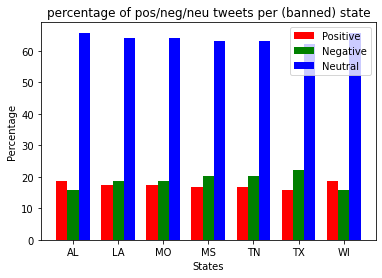

In [63]:
positive = banned['positive'].to_numpy().tolist()
negative = banned['negative'].to_numpy().tolist()
neutral = banned['neutral'].to_numpy().tolist()
location = banned['Location'].to_numpy().tolist()

N = len(location)
ind = np.arange(N) 
width = 0.25
  
bar1 = plt.bar(ind, positive, width, color = 'r')
  
bar2 = plt.bar(ind+width, negative, width, color='g')
  
bar3 = plt.bar(ind+width*2, neutral, width, color = 'b')
  
plt.xlabel("States")
plt.ylabel('Percentage')
plt.title("percentage of pos/neg/neu tweets per (banned) state")
  
plt.xticks(ind+width,location)
plt.legend( (bar1, bar2, bar3), ('Positive', 'Negative', 'Neutral') )
plt.show()

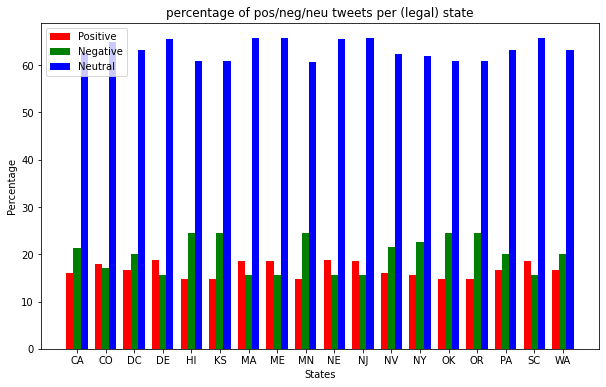

In [74]:
positive = legal['positive'].to_numpy().tolist()
negative = legal['negative'].to_numpy().tolist()
neutral = legal['neutral'].to_numpy().tolist()
location = legal['Location'].to_numpy().tolist()

N = len(location)
ind = np.arange(N) 
width = 0.25
plt.figure(figsize=(10,6))
bar1 = plt.bar(ind, positive, width, color = 'r')
  
bar2 = plt.bar(ind+width, negative, width, color='g')
  
bar3 = plt.bar(ind+width*2, neutral, width, color = 'b')
  
plt.xlabel("States")
plt.ylabel('Percentage')
plt.title("percentage of pos/neg/neu tweets per (legal) state")
  
plt.xticks(ind+width,location)
plt.legend( (bar1, bar2, bar3), ('Positive', 'Negative', 'Neutral') )
plt.show()

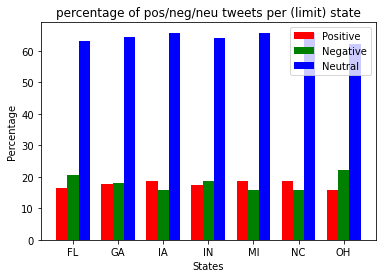

In [79]:
positive = limit['positive'].to_numpy().tolist()
negative = limit['negative'].to_numpy().tolist()
neutral = limit['neutral'].to_numpy().tolist()
location = limit['Location'].to_numpy().tolist()

N = len(location)
ind = np.arange(N) 
width = 0.25
bar1 = plt.bar(ind, positive, width, color = 'r')
  
bar2 = plt.bar(ind+width, negative, width, color='g')
  
bar3 = plt.bar(ind+width*2, neutral, width, color = 'b')
  
plt.xlabel("States")
plt.ylabel('Percentage')
plt.title("percentage of pos/neg/neu tweets per (limit) state")
  
plt.xticks(ind+width,location)
plt.legend( (bar1, bar2, bar3), ('Positive', 'Negative', 'Neutral') )
plt.show()

# 5. Modelling

In [19]:
import numpy as np

ar = final_df.Location.unique()
print(np.sort(ar))

['AL' 'CA' 'CO' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'IN' 'KS' 'LA' 'MA' 'ME'
 'MI' 'MN' 'MO' 'MS' 'NC' 'NE' 'NJ' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'SC'
 'TN' 'TX' 'WA' 'WI']


In [20]:
final_df1 = final_df.assign(label='')

In [21]:
banned = ['AL','LA','MS','MO','TN','TX','WV','WI']
limit = ['FL','IA','GA','NC','IN','OH','MI']

final_df1.loc[final_df1['Location'].isin(banned),'label'] = 'banned'
final_df1.loc[final_df1['Location'].isin(limit),'label'] = 'limit'
final_df1.loc[final_df1['label'] == '','label'] = 'legal'

In [22]:
final_df1

Tweet Location   label
0       Democratic senators need to shut up and come u...       WI  banned
1       Overturning #RoeVWade is a public health crisi...       OH   limit
2       SIGN NOW -&gt; Demand Congress stand up immedi...       DE   legal
3                       #RoeVWade https://t.co/VYMtMZVuHH       OH   limit
4       This days it all. #RoeVWade https://t.co/JvMFK...       WA   legal
...                                                   ...      ...     ...
149995  I may seem okay, but I get randomly choked up/...       MN   legal
149996  @myrnamelgar Constitutional scholar Myrna Melg...       MO  banned
149997  All Out for Abortion Rights! in Downtown Sprin...       MO  banned
149998                                                  .       CO   legal
149999                                          6/24/2022       MN   legal

[146940 rows x 3 columns]

In [27]:
df = law_per_state
df

0         banned
1          limit
2          legal
3          limit
4          legal
           ...  
149995     legal
149996    banned
149997    banned
149998     legal
149999     legal
Name: label, Length: 146940, dtype: object

In [31]:
!pip3 install -U scikit-learn

     |████████████████████████████████| 8.6MB 5.7MB/s eta 0:00:01
     |████████████████████████████████| 34.2MB 31.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/61/cf/6e354304bcb9c6413c4e02a747b600061c21d38ba51e7e544ac7bc66aecc/threadpoolctl-3.1.0-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = law_per_state
y = df['label']
x = df

X_train, X_test, y_train, y_test  = train_test_split(x,y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
#print(X_test.groupby('category').size())


X_test = X_test.drop(['label'],axis=1)

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


X_test.columns = X_test.columns.str.strip()
X_train.columns = X_train.columns.str.strip()

X_test=X_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)


In [39]:
from nltk.tokenize import word_tokenize,WordPunctTokenizer
from nltk.corpus import stopwords

#test set tokenization

test_lowercase = []
clean_test_words = []
clean_test_words_str = []
tokenizer = WordPunctTokenizer()
for word in X_test['Tweet']:
    test_lowercase.append(tokenizer.tokenize(word.lower()))

stop_words = set(stopwords.words('english'))

i=0
for x in range(0,len(test_lowercase)):
    
    clean_test_words.append([token for token in test_lowercase[x] if not token in stop_words and token.isalpha()])
    clean_test_words_str.append(" ".join(clean_test_words[i]))
    i+=1

In [40]:
#train set tokenization

lowercase = []
clean_words = []
clean_words_str = []
tokenizer = WordPunctTokenizer()
for word in X_train['Tweet']:
    lowercase.append(tokenizer.tokenize(word.lower()))

stop_words = set(stopwords.words('english'))

i=0
for x in range(0,len(lowercase)):
    
    clean_words.append([token for token in lowercase[x] if not token in stop_words and token.isalpha()])
    clean_words_str.append(" ".join(clean_words[i]))
    i+=1

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=100, sublinear_tf=True, min_df=7) 
tfidf = tfidf_vectorizer.fit_transform(clean_words_str)

tfidf_test = tfidf_vectorizer.transform(clean_test_words_str)


In [45]:
X = tfidf.toarray()
X_te = tfidf_test.toarray()

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid based on the results of random search 
param_grid = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, scoring = 'accuracy')

clf.fit(X, y_train)
print(clf.best_params_)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

{'max_depth': 10, 'max_features': 1}


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(max_depth = 10, max_features= 3)
clf.fit(X, y_train)
Y_pred = clf.predict(X_te) 

confusion_matrix(y_test,Y_pred) 
print(classification_report(y_test,Y_pred))

acc = cross_val_score(clf, X,y_train,scoring="accuracy", cv=10)

accuracy_score(y_test, Y_pred)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5817
           1       0.53      1.00      0.69     15613
           2       0.00      0.00      0.00      7958

    accuracy                           0.53     29388
   macro avg       0.18      0.33      0.23     29388
weighted avg       0.28      0.53      0.37     29388



0.5312712671838846

In [53]:
print(acc)

[0.53130316 0.53130316 0.53126329 0.53126329 0.53126329 0.53126329
 0.53126329 0.53126329 0.53126329 0.53126329]
